# Approval status comparison

In [56]:
from therapy.database import Database
from boto3.dynamodb.conditions import Key

db = Database(db_url="http://localhost:8000")

***Using Therapy Database Endpoint: http://localhost:8000***


### Construct approval_status group values

In [80]:
def scan_approval_status():
    status_groups = []  # key: "concept_id,concept_id,concept_id", value: [list, of, approval, status, strings]
    total_groups = 0
    last_evaluated_key = None
    

    while True:
        if last_evaluated_key:
            response = db.therapies.scan(ExclusiveStartKey=last_evaluated_key)
        else:
            response = db.therapies.scan()
        for record in response["Items"]:
            if record["item_type"] == "identity" and record.get("merge_ref") is not None:
                continue
            elif record["item_type"] != "merger":
                continue            
            total_groups += 1
            
            concept_ids = [record["concept_id"]] + record["xrefs"]
            statuses = record.get("approval_status")
            if not statuses:
                continue
            elif isinstance(statuses, str):
                statuses = [statuses]
            assert isinstance(statuses, list)
            if statuses:
                status_groups.append([concept_ids, statuses])
        last_evaluated_key = response.get("LastEvaluatedKey")
        if last_evaluated_key is None:
            break
    print(f"groups with statuses: {len(status_groups)}")
    print(f"total groups: {total_groups}")
    return status_groups



In [82]:
groups = scan_approval_status()
import json
with open('approval_status.json', 'w', encoding='utf-8') as f:
    json.dump(groups, f, ensure_ascii=False, indent=2)

groups with statuses: 8418
total groups: 15925


In [123]:
import matplotlib.pyplot as plt
import itertools
from therapy.schemas import ApprovalStatus
import numpy as np

In [122]:
# there's probably a better way to do this but whatever
tmp_values = [v.value for v in list(ApprovalStatus.__members__.values())]
index_getter = {v: i for v,i in zip(tmp_values, range(len(tmp_values)))}
index_getter

{'chembl_phase_0': 0,
 'chembl_phase_1': 1,
 'chembl_phase_2': 2,
 'chembl_phase_3': 3,
 'chembl_phase_4': 4,
 'chembl_withdrawn': 5,
 'fda_otc': 6,
 'fda_prescription': 7,
 'fda_discontinued': 8,
 'fda_tentative': 9,
 'hemonc_approved': 10,
 'gtopdb_approved': 11,
 'gtopdb_withdrawn': 12,
 'rxnorm_prescribable': 13}

In [139]:
counts = {}
for _, statuses in groups:
    hashed = tuple(set(statuses))
    if hashed in counts:
        counts[hashed] += 1
    else:
        counts[hashed] = 1
counts_multiple = {g: v for g, v in counts.items() if len(g) > 1}

heats = np.zeros([14, 14])
for g, v in counts_multiple.items():
    combos = itertools.combinations(g, 2)
    for combo in combos:
        i_1, i_2 = index_getter[combo[0]], index_getter[combo[1]]
        heats[i_1][i_2] += v
        heats[i_2][i_1] += v

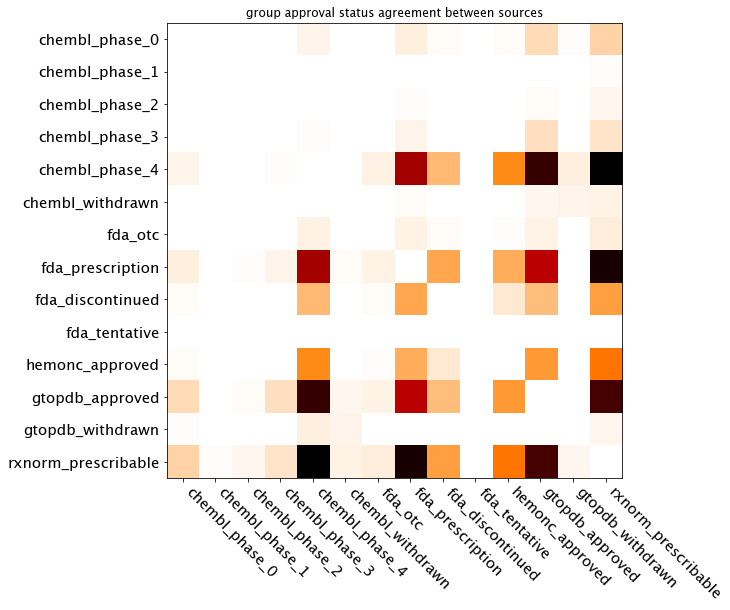

In [183]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
im = plt.imshow(heats, cmap='gist_heat_r', interpolation='nearest')
ax.tick_params(labelsize=15)
ax.set_xticks(np.arange(len(index_getter)))
ax.set_xticklabels(list(index_getter.keys()), rotation=-45, ha="left")

ax.set_yticks(np.arange(len(index_getter)))
ax.set_yticklabels(list(index_getter.keys()))
plt.title("group approval status agreement between sources")
plt.tight_layout()
plt.savefig("approval_heatmap.png", facecolor='white', transparent=False)
plt.show()


In [181]:
np.set_printoptions(suppress=True)
heats

array([[   0.,    1.,    2.,    2.,   31.,    3.,    2.,   48.,   15.,
           0.,   15.,   99.,    9.,  121.],
       [   1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    8.],
       [   2.,    0.,    0.,    1.,    4.,    0.,    0.,    7.,    0.,
           0.,    1.,   16.,    0.,   25.],
       [   2.,    0.,    1.,    0.,    8.,    0.,    1.,   28.,    3.,
           0.,    5.,   93.,    0.,   74.],
       [  31.,    0.,    4.,    8.,    0.,    0.,   39.,  802.,  197.,
           0.,  324., 1211.,   49., 1407.],
       [   3.,    0.,    0.,    0.,    0.,    0.,    1.,   12.,    5.,
           0.,    3.,   23.,   30.,   37.],
       [   2.,    0.,    0.,    1.,   39.,    1.,    0.,   37.,   16.,
           0.,   10.,   34.,    1.,   51.],
       [  48.,    0.,    7.,   28.,  802.,   12.,   37.,    0.,  247.,
           0.,  229.,  724.,    2., 1311.],
       [  15.,    0.,    0.,    3.,  197.,    5.,   16.,  247.,    0.,
         

### Sidebar: Query success of drugs@fda -> rxcui lookups

In [45]:
def scan_drugsatfda():    
    drugsatfda_records = 0
    successful_refs = 0

    last_evaluated_key = None
    
    while True:
        if last_evaluated_key:
            response = db.therapies.scan(ExclusiveStartKey=last_evaluated_key)
        else:
            response = db.therapies.scan()
        for record in response["Items"]:
            if record["item_type"] == "identity" and record["src_name"] == "DrugsAtFDA":
                drugsatfda_records += 1
                rxnorm_refs = [x for x in record.get("xrefs", []) if x.startswith("rx")]
                for ref in rxnorm_refs:
                    rxnorm_record = db.get_record_by_id(ref)
                    if rxnorm_record:
                        successful_refs += 1
                        print(record)
                        print(rxnorm_record)

        last_evaluated_key = response.get("LastEvaluatedKey")
        if last_evaluated_key is None:
            break
    print(drugsatfda_records)
    print(successful_refs)
            

Overall drugs@fda records vs valid rxcui references:

In [46]:
scan_drugsatfda()

24511
0
